# Chapter 5 Modeling Infectious Diseases

*Editor: Weipeng Xu*

*Last modified: 24/06/2025*

*Reference: Sundnes, Joakim. Solving Ordinary Differential Equations in Python. Springer Nature, 2024.*

## Derivation of the SIR model

The SIR model is a classical model for predicting epidemic dynamics, which is derived from three categories: **Susceptible (S)**, **Infected (I)**, and **Recovered (R)**. With several assumptions and simplifications, we can obtain the difference equations:
$$
\begin{aligned}
&\frac{S(t+\Delta t)-S(t)}{\Delta t} = -\beta\frac{S(t)I(t)}{N}\\
&\frac{I(t+\Delta t)-I(t)}{\Delta t} = \beta\frac{S(t)I(t)}{N}-\nu I(t)\\
&\frac{R(t+\Delta t)-R(t)}{\Delta t} = \nu I(t)
\end{aligned}
$$
where $S$, $I$, and $R$ are the number of people in each category. $N=S+I+R$. $\beta$ is a constant representing the probability of an infected person ecounting and infecting a susceptible person. $\nu$ is a constant that describes the time dynamics of the disease and $1/\nu$ is the average recovery time. Then we can obatin the ODE system bny letting $\Delta t\rightarrow 0$:
$$
\begin{aligned}
&S^{\prime}(t) = -\beta\frac{SI}{N}\\
&I^{\prime}(t) = \beta\frac{SI}{N}-\nu I\\
&R^{\prime}(t) = \nu I
\end{aligned}
$$

> Another important concept is the basic reproduction number $R_0$ of an epidemic, which represent the average number of new individuals infected by a single infected person. In the simple model considered here, we have:
$$
R_0 = \frac{\beta}{\nu}
$$

For typical parameter values, the models are not stiff. So we can solve the SIR model using the fourth-order RK method:

In [1]:
import numpy as onp
import matplotlib.pyplot as plt

class ODESolver:

    def __init__(self,f):
        self.model = f
        self.f = lambda t,u: onp.asarray(f(t,u), dtype=float)

    def set_initial_condition(self, u0):
        self.u0 = onp.asarray(u0, dtype=float)

    def solve(self, t_span, N):
        t0, T = t_span
        self.dt = (T-t0)/N
        self.t = onp.zeros((N+1, 1))
        self.u = onp.zeros((N+1, self.u0.size))

        msg = "Please set initial condition before calling solve"
        assert hasattr(self, "u0"), msg

        self.t[0] = t0
        self.u[0] = self.u0

        for n in range(N):
            self.n = n
            self.t[n+1] = self.t[n] + self.dt
            self.u[n+1] = self.advance()
        
        return self.t, self.u
    
    def advance(self):
        raise NotImplementedError("Advance method is not implemented in the based class")


class RungeKutta4(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        k1 = f(t[n], u[n])
        k2 = f(t[n] + dt/2., u[n] + dt/2.*k1)
        k3 = f(t[n] + dt/2., u[n] + dt/2.*k2)
        k4 = f(t[n] + dt, u[n] + dt*k3)
        return u[n] + 1/6. * dt * (k1 + 2*k2 + 2*k3 + k4)

In [2]:
class SIR:
    def __init__(self, beta, nu):
        self.beta = beta
        self.nu = nu
    
    def __call__(self, t, u):
        S, I, R = u[0], u[1], u[2]
        dS = -self.beta * S * I
        dI = self.beta * S * I - self.nu * I
        dR = self.nu * I
        return [dS, dI, dR]

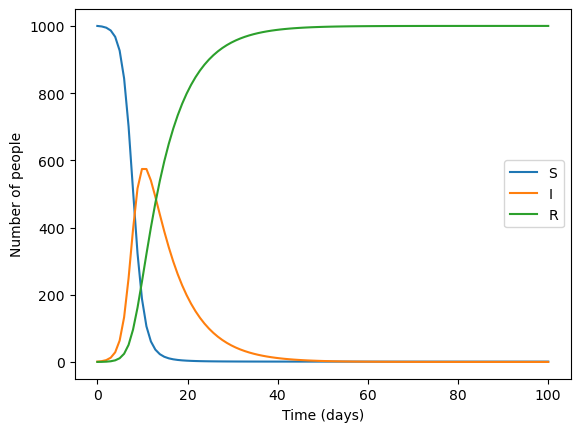

In [3]:
# parameters
beta = 0.001
nu = 1 /7.

# initial value
S0 = 1000
I0 = 1
R0 = 0

# model
SIR_model = SIR(beta, nu)
solver = RungeKutta4(SIR_model)
solver.set_initial_condition([S0, I0, R0])

# solve
t_span = (0, 100)
t, u = solver.solve(t_span, N=101)
S = u[:, 0]
I = u[:, 1]
R = u[:, 2]

# plot
plt.plot(t, S, t, I, t, R)
plt.xlabel("Time (days)")
plt.ylabel("Number of people")
plt.legend(['S', 'I', 'R'])
plt.show()

## Extending the SIR model

### An SIR model without life-long immunity

We can also consider a leakage of people from $R$ back to $S$, which is achieved by introducing the parameter $\gamma$ to describe this flux, and $1/\gamma$ can be considered as the mean time for immunity:
$$
\begin{aligned}
&S^{\prime}(t) = -\beta\frac{SI}{N}+\gamma R\\
&I^{\prime}(t) = \beta\frac{SI}{N}-\nu I\\
&R^{\prime}(t) = \nu I-\gamma R
\end{aligned}
$$

In [4]:
class SIR:
    def __init__(self, beta, nu, gamma):
        self.beta = beta
        self.nu = nu
        self.gamma = gamma
    
    def __call__(self, t, u):
        S, I, R = u[0], u[1], u[2]
        dS = -self.beta * S * I + self.gamma * R
        dI = self.beta * S * I - self.nu * I
        dR = self.nu * I - self.gamma * R
        return [dS, dI, dR]

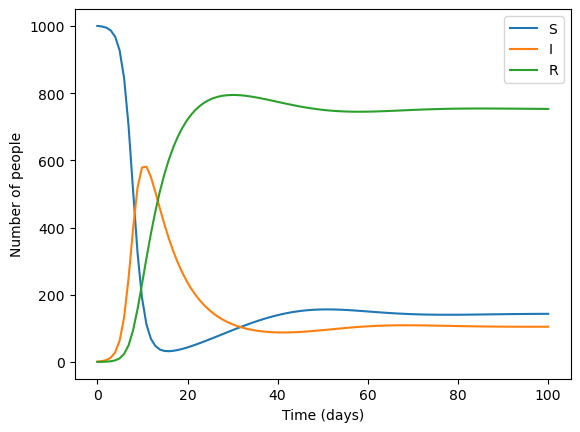

In [5]:
# parameters
beta = 0.001
nu = 1 / 7.
gamma = 1 / 50.

# initial value
S0 = 1000
I0 = 1
R0 = 0

# model
SIR_model = SIR(beta, nu, gamma)
solver = RungeKutta4(SIR_model)
solver.set_initial_condition([S0, I0, R0])

# solve
t_span = (0, 100)
t, u = solver.solve(t_span, N=101)
S = u[:, 0]
I = u[:, 1]
R = u[:, 2]

# plot
plt.plot(t, S, t, I, t, R)
plt.xlabel("Time (days)")
plt.ylabel("Number of people")
plt.legend(['S', 'I', 'R'])
plt.show()

### A SEIR model to capture incubation period

We can also consider the incubation period $E$ between $S$ and $I$, where they can also infect others:
$$
\begin{aligned}
&S^{\prime}(t) = -\beta\frac{SI}{N}+\gamma R\\
&E^{\prime}(t) = \beta\frac{SI}{N}-\mu E\\
&I^{\prime}(t) = \mu E-\nu I\\
&R^{\prime}(t) = \nu I-\gamma R
\end{aligned}
$$
 

In [6]:
class SEIR:
    def __init__(self, beta ,mu, nu, gamma):
        self.beta = beta
        self.mu = mu
        self.nu = nu
        self.gamma = gamma
    
    def __call__(self, t, u):
        S, E, I, R = u
        N = S + E + I + R
        dS = -self.beta * S * I / N + self.gamma * R
        dE = self.beta * S * I / N - self.mu * E
        dI = self.mu * E - self.nu * I
        dR = self.nu * I - self.gamma * R
        return [dS, dE, dI, dR]

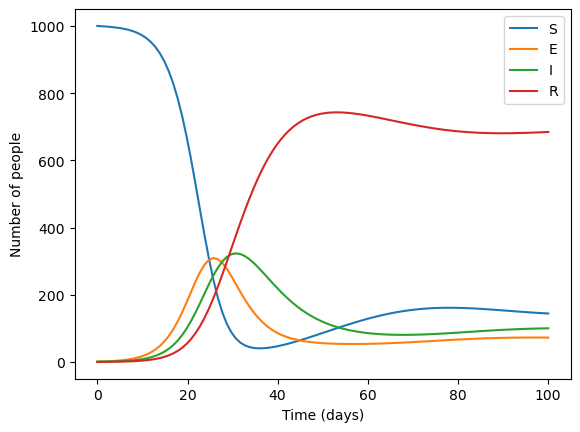

In [7]:
# parameters
beta = 1.0
mu = 1 / 5.
nu = 1 / 7.
gamma = 1 / 50.

# initial value
S0 = 1000
E0 = 0
I0 = 1
R0 = 0

# model
SEIR_model = SEIR(beta, mu, nu, gamma)
solver = RungeKutta4(SEIR_model)
solver.set_initial_condition([S0, E0, I0, R0])

# solve
t_span = (0, 100)
t, u = solver.solve(t_span, N=101)
S = u[:, 0]
E = u[:, 1]
I = u[:, 2]
R = u[:, 3]

# plot
plt.plot(t, S, t, E, t, I, t, R)
plt.xlabel("Time (days)")
plt.ylabel("Number of people")
plt.legend(['S', 'E', 'I', 'R'])
plt.show()

## A model of the Covid-19 pandemic

We cosider a SEEIIR model to model the Covid-19:
$$
\begin{aligned}
&S^{\prime}(t) = -\beta\frac{SI}{N}-r_{ia}\beta\frac{SI_a}{N}-r_{e2}\beta\frac{SE_2}{N}\\
&E_1^{\prime}(t) = \beta\frac{SI}{N}+r_{ia}\beta\frac{SI_a}{N}+r_{e2}\beta\frac{SE_2}{N}-\lambda_1 E_1\\
&E_2^{\prime}(t) = \lambda_1(1-p_a)E_1 - \lambda_2E_2\\
&I^{\prime}(t) = \lambda_2 E_2-\mu I\\
&I_a^{\prime}(t) = \lambda_1p_a E_1-\mu I_a\\
&R^{\prime}(t) = \mu (I+I_a)
\end{aligned}
$$
For details of this model, please refer to P88~94. The implementation can be written as:

In [8]:
class SEEIIR:
    def __init__(self, beta=0.33, r_ia=0.1,r_e2=1.25,
                 lmbda_1=0.33, lmbda_2=0.5, p_a=0.4, mu=0.2):
        self.beta = beta
        self.r_ia = r_ia
        self.r_e2 = r_e2
        self.lmbda_1 = lmbda_1
        self.lmbda_2 = lmbda_2
        self.p_a = p_a
        self.mu = mu
    
    def __call__(self, t, u):
        beta = self.beta
        r_ia = self.r_ia
        r_e2 = self.r_e2
        lmbda_1 = self.lmbda_1
        lmbda_2 = self.lmbda_2
        p_a = self.p_a
        mu = self.mu

        S, E1, E2, I, Ia, R = u
        N = sum(u)
        dS = -beta * S * I / N - r_ia * beta * S * Ia / N \
             -r_e2 * beta * S * E2 / N
        dE1 = beta * S * I / N + r_ia * beta * S * Ia / N \
             + r_e2 * beta * S * E2 / N - lmbda_1 * E1
        dE2 = lmbda_1 * (1 - p_a) * E1 - lmbda_2 * E2
        dI = lmbda_2 * E2 - mu * I
        dIa = lmbda_1 * p_a * E1 - mu * Ia
        dR = mu * (I + Ia)
        return [dS, dE1, dE2, dI, dIa, dR]

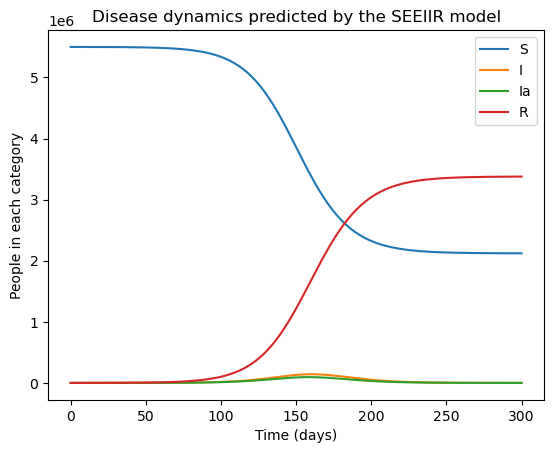

In [9]:
# initial value
S_0 = 5.5e6
E1_0 = 0
E2_0 = 100
I_0 = 0
Ia_0 = 0
R_0 = 0
U0 = [S_0, E1_0, E2_0, I_0, Ia_0, R_0]

# model
SEEIIR_model = SEEIIR()
solver = RungeKutta4(SEEIIR_model)
solver.set_initial_condition(U0)

# solve
t_span = (0, 300)
t, u = solver.solve(t_span, N=200)
S = u[:, 0]
E1 = u[:, 1]
E2 = u[:, 2]
I = u[:, 3]
Ia = u[:, 4]
R = u[:, 5]

# plot
plt.plot(t, S, t, I, t, Ia, t, R)
plt.xlabel("Time (days)")
plt.ylabel("Number of people")
plt.legend(['S', 'I', 'Ia', 'R'])
plt.title('Disease dynamics predicted by the SEEIIR model')
plt.xlabel('Time (days)')
plt.ylabel('People in each category')
plt.show()